# SCPI simulation

SCPI are financial instruments, open to retail investors in France, that enable investing in real estate companies. Their benefit is an access to real estate markets at a much lower entry ticket than buying real estate directly.

There are hundreeds of possible SCPI choices. Which one is best?

In particular I'm comparing along two dimenssions:
- which company is best
- which investment option ("en direct" or "en demembrement")

**Conclusion is that the best is to choose low fee companies "en demembrement".**

In [1]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt

# Functions

In [2]:
def get_direct_info(
    apport,
    cotisation_sociales,
    tranche_marginale_impo,
    tdvm,
    revalorisation_sous_jacent,
    frais_souscription,
    max_annees_simulation
):
    df = pd.DataFrame(
        {
            "annee": np.arange(0, max_annees_simulation+1),
            "cotisation_sociales": cotisation_sociales if type(cotisation_sociales)==list else [cotisation_sociales] * (max_annees_simulation+1),
            "tranche_marginale_impo": tranche_marginale_impo if type(tranche_marginale_impo)==list else [tranche_marginale_impo] * (max_annees_simulation+1),
            "tdvm": tdvm if type(tdvm)==list else [tdvm] * (max_annees_simulation+1),
            "revalorisation_sous_jacent": revalorisation_sous_jacent if type(revalorisation_sous_jacent)==list else [revalorisation_sous_jacent] * (max_annees_simulation+1),
            "frais_souscription": frais_souscription if type(frais_souscription)==list else [frais_souscription] * (max_annees_simulation+1)
        }
    )

    # Initialise year 0
    df.loc[0, "valeur_sous_jacent"] = apport
    df.loc[0, "loyers"] = None
    df.loc[0, "impots_et_cs"] = None
    df.loc[0, "loyers_net"] = None
    df.loc[0, "cash_flow"] = -apport
    df.loc[0, "cum_cash_flow"] = -apport
    df.loc[0, "cash_flow_if_exit"] = -apport
    df.loc[0, "cum_cash_flow_if_exit"] = -apport

    for i in range(1, len(df)):
        df.loc[i,"valeur_sous_jacent"] = df.loc[i-1,"valeur_sous_jacent"]*(1+df.loc[i, "revalorisation_sous_jacent"])
        if i == 1:
            df.loc[i, "loyers"] = 52
        else:
            df.loc[i, "loyers"] = df.loc[i, "valeur_sous_jacent"] * df.loc[i, "tdvm"] / 12
        df.loc[i, "impots_et_cs"] = df.loc[i, "loyers"]*(df.loc[i, "cotisation_sociales"]+df.loc[i, "tranche_marginale_impo"])
        df.loc[i, "loyers_net"] = (df.loc[i, "loyers"] - df.loc[i, "impots_et_cs"])*12
        df.loc[i, "cash_flow"] = df.loc[i, "loyers_net"]
        df.loc[i, "cum_cash_flow"] = df.loc[i-1, "cum_cash_flow"] + df.loc[i, "cash_flow"]
        df.loc[i, "cash_flow_if_exit"] = df.loc[i, "cash_flow"] + df.loc[i, "valeur_sous_jacent"]*(1-df.loc[i, "frais_souscription"])
        df.loc[i, "cum_cash_flow_if_exit"] = df.loc[0:(i-1),"cash_flow"].sum() + df.loc[i, "cash_flow_if_exit"]
        df.loc[i, "irr_if_exit"] = npf.irr(df.loc[0:(i-1),"cash_flow"].to_list() + [df.loc[i, "cash_flow_if_exit"]]) * 100

    return df

In [3]:
def get_demembrement_info(
    apport,
    clee_de_repartition,
    revalorisation_sous_jacent,
    frais_souscription
):
    df = pd.DataFrame(
        {
            "annee": [i for i in range(len(clee_de_repartition))],
            "revalorisation_sous_jacent": revalorisation_sous_jacent if type(revalorisation_sous_jacent)==list else [revalorisation_sous_jacent] * len(clee_de_repartition),
            "frais_souscription": frais_souscription if type(frais_souscription)==list else [frais_souscription] * len(clee_de_repartition),
            "clee_de_repartition": clee_de_repartition
        }
    )

    df.loc[0, "valeur_sous_jacent"] = apport
    df.loc[0, "cash_flow"] = -apport
    df.loc[0, "cum_cash_flow"] = -apport
    df.loc[0, "cash_flow_if_exit"] = -apport
    df.loc[0, "cum_cash_flow_if_exit"] = -apport

    for i in range(1, len(df)):
        df.loc[i,"valeur_sous_jacent"] = df.loc[i-1,"valeur_sous_jacent"]*(1+df.loc[i, "revalorisation_sous_jacent"])
        df.loc[i, "cash_flow"] = 0
        df.loc[i, "cum_cash_flow"] = df.loc[i-1, "cum_cash_flow"] + df.loc[i, "cash_flow"]
        if df.loc[i, "clee_de_repartition"] > 0:
            df.loc[i, "cash_flow_if_exit"] = df.loc[i-1, "valeur_sous_jacent"] / df.loc[i, "clee_de_repartition"] * (1-df.loc[i, "frais_souscription"])
            df.loc[i, "cum_cash_flow_if_exit"] = df.loc[0:(i-1),"cash_flow"].sum() + df.loc[i, "cash_flow_if_exit"]
            df.loc[i, "irr_if_exit"] = npf.irr(df.loc[0:(i-1),"cash_flow"].to_list() + [df.loc[i, "cash_flow_if_exit"]]) * 100

    return df

In [4]:
def plot_irr(xs, ys, labels, title):
    plt.figure(figsize=(15, 7))
    for x, y, label in zip(xs, ys, labels):
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.grid()
    plt.ylim(-2, 5)
    plt.xlim(0, 20)
    plt.xlabel("annees")
    plt.ylabel("TRI (%)")
    plt.xticks(x, x)
    plt.legend()
    plt.show()
    
def plot_cum_cash_flow(xs, ys, labels, title):
    plt.figure(figsize=(15, 7))
    for x, y, label in zip(xs, ys, labels):
        plt.plot(x, y, label=label)
    plt.title(title)
    plt.grid()
    plt.xlim(0, 20)
    plt.xlabel("annees")
    plt.ylabel("Cumulative Cash-flow (€)")
    plt.xticks(x, x)
    plt.legend()
    plt.show()

# Quelle SCPI est la plus interessante?

## En demembrement

In [16]:
def get_data_demembrement():
    data_demembrement = pd.read_csv("scpi_demembrement.csv")
    data_demembrement = data_demembrement.replace(to_replace="X", value=None)
    data_demembrement = data_demembrement.replace(to_replace=",", value=".", regex=True)
    data_demembrement = data_demembrement.replace(to_replace="%", value="", regex=True)
    data_demembrement = data_demembrement.replace(to_replace="ans", value="", regex=True)
    data_demembrement = data_demembrement.dropna(axis=1)

    frais_souscription = data_demembrement.iloc[0, 1:].astype(float) / 100
    
    tmp = data_demembrement.loc[1:].rename(columns={"SCPI": "annee"})
    tmp["annee"] = tmp["annee"].astype(int)
    clee_repartition = pd.DataFrame({"annee": np.arange(0, 21)}).merge(
        tmp,
        how="left",
        on="annee"
    )
    clee_repartition.iloc[:, 1:] = clee_repartition.iloc[:, 1:].astype(float) / 100
    
    return frais_souscription, clee_repartition

frais_souscription, clee_repartition = get_data_demembrement()

/var/folders/2j/4p6d36k160v2dh6kk726g81h0000gq/T/ipykernel_93961/2803740073.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clee_repartition.iloc[:, 1:] = clee_repartition.iloc[:, 1:].astype(float) / 100


In [17]:
df_cash_flow_if_exit = pd.DataFrame({"annee": np.arange(0, 21)})
df_irr_if_exit = pd.DataFrame({"annee": np.arange(0, 21)})

for scpi_name in frais_souscription.index:
    demembrement_info = get_demembrement_info(
        apport=10000,
        clee_de_repartition=clee_repartition[scpi_name],
        revalorisation_sous_jacent=0.005,
        frais_souscription=frais_souscription[scpi_name],
    )
    
    df_cash_flow_if_exit[scpi_name] = demembrement_info["cum_cash_flow_if_exit"]
    df_irr_if_exit[scpi_name] = demembrement_info["irr_if_exit"]
    
df_cash_flow_if_exit.head()

,annee,ActivImmo,Buroboutic,Cap Foncières et Territoires,Cap'HebergImmo,CM Pierre 1,Coeur d'Europe,Coeur de Régions,Coeur de Ville,Corum Eurion,...,PFO2,Pierre Capitale,Pierre Rendement,Pierval Santé,Placement Pierre,Primovie,Urban Coeur Commerce,SelectInvest 1,Selectipierre 2,Vendôme Régions
0,0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,438.871098,156.675978,213.735955,271.440678,382.379888,157.965714,275.398844,157.965714,216.344828,...,383.964888,213.735955,327.221910,329.958543,385.567797,327.221910,43.186441,579.870810,-57.600902,821.696429
4,4,1066.794655,622.879215,747.854265,747.854265,796.174740,509.013059,827.468000,634.120357,634.120357,...,799.927202,685.001316,803.723553,814.175350,867.274868,867.274868,571.196568,1001.536759,330.826724,1278.612500


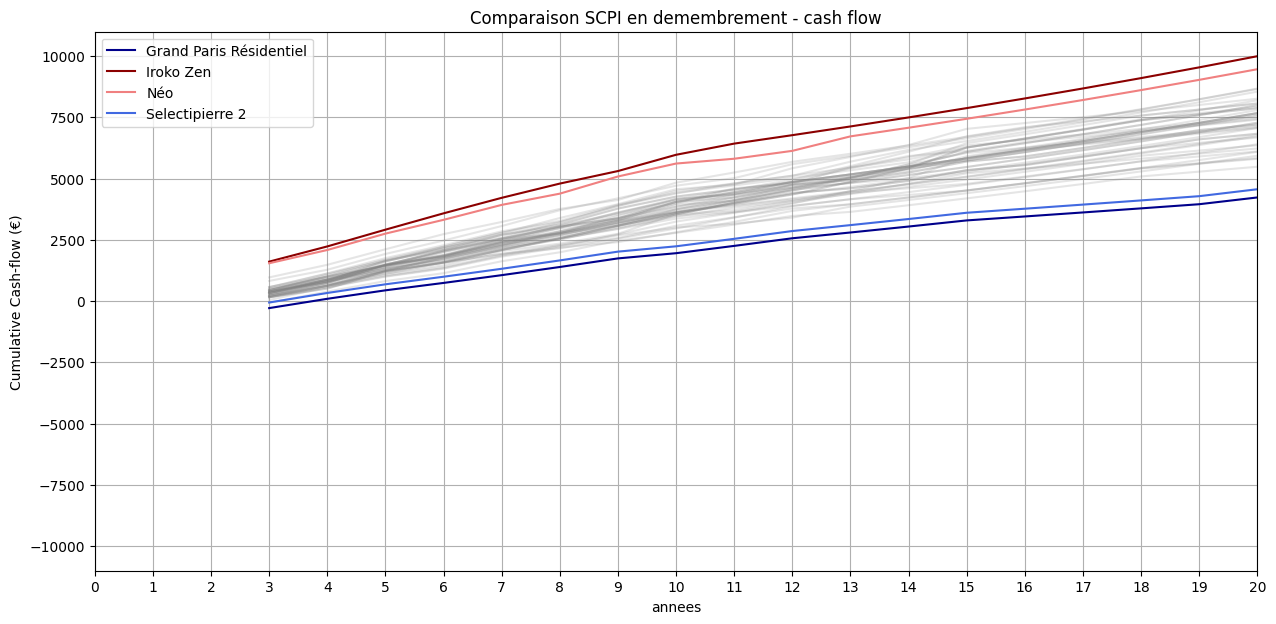

In [18]:
plt.figure(figsize=(15, 7))
for scpi_name in df_cash_flow_if_exit.columns:
    if scpi_name == "annee":
        continue
    elif scpi_name == "Iroko Zen":
        color="darkred"
        label=scpi_name
        alpha=1
    elif scpi_name == "Néo":
        color="lightcoral"
        label=scpi_name
        alpha=1
    elif scpi_name == "Selectipierre 2":
        color="royalblue"
        label=scpi_name
        alpha=1
    elif scpi_name == "Grand Paris Résidentiel":
        color="darkblue"
        label=scpi_name
        alpha=1
    else:
        color="grey"
        label=None
        alpha=.2
        
    plt.plot(df_cash_flow_if_exit["annee"], df_cash_flow_if_exit[scpi_name], color=color, label=label, alpha=alpha)

plt.title("Comparaison SCPI en demembrement - cash flow")
plt.grid()
plt.xlim(0, 20)
plt.xlabel("annees")
plt.ylabel("Cumulative Cash-flow (€)")
plt.xticks(df_cash_flow_if_exit["annee"], df_cash_flow_if_exit["annee"])
plt.legend()
plt.show()

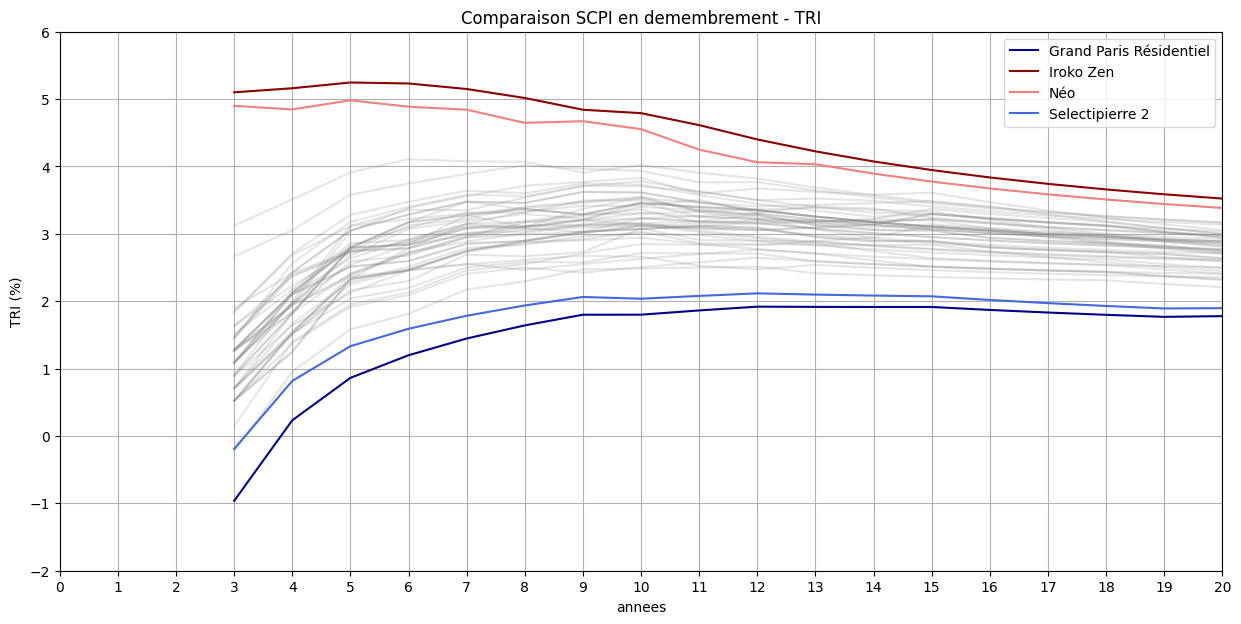

In [19]:
plt.figure(figsize=(15, 7))
for scpi_name in df_cash_flow_if_exit.columns:
    if scpi_name == "annee":
        continue
    elif scpi_name == "Iroko Zen":
        color="darkred"
        label=scpi_name
        alpha=1
    elif scpi_name == "Néo":
        color="lightcoral"
        label=scpi_name
        alpha=1
    elif scpi_name == "Selectipierre 2":
        color="royalblue"
        label=scpi_name
        alpha=1
    elif scpi_name == "Grand Paris Résidentiel":
        color="darkblue"
        label=scpi_name
        alpha=1
    else:
        color="grey"
        label=None
        alpha=.2
        
    plt.plot(df_irr_if_exit["annee"], df_irr_if_exit[scpi_name], color=color, label=label, alpha=alpha)

plt.title("Comparaison SCPI en demembrement - TRI")
plt.grid()
plt.ylim(-2, 6)
plt.xlim(0, 20)
plt.xlabel("annees")
plt.ylabel("TRI (%)")
plt.xticks(df_irr_if_exit["annee"], df_irr_if_exit["annee"])
plt.legend()
plt.show()

Conclusion:
- En demembrement il y a clairement des SCPI meilleures que d'autres. Les SCPI sans frais (e.g., Iroko Zen, Neo) offrent les meilleurs rendements. D'autres (e.g., Grand Paris Residentiel) se foutent de notre geule, puisque leur cash-flow est negatif.
- En demembrement, la forme du TRI en fonction du temps est differente chez les SCPI avec frais et les SCPI sans frais. Avec frais, on veut typiquement investir pour 6-8 ans. Sans frais, on peut partir sur des durees plus courtes (e.g., 3-5 ans)

Analyses a venir:
- Est-ce qu'il vaut mieux investir en direct ou en demembrement?

## En direct

In [20]:
scpi_info = pd.read_csv("scpi_info.csv")

scpi_info["TD 2021"] = scpi_info["TD 2021"].replace(to_replace="/", value=None, regex=True)
scpi_info["TD 2021"] = scpi_info["TD 2021"].replace(to_replace=",", value=".", regex=True)
scpi_info["TD 2021"] = scpi_info["TD 2021"].replace(to_replace="%", value="", regex=True)
scpi_info["TD 2021"] = scpi_info["TD 2021"].astype(float) / 100

scpi_info["frais_souscription"] = scpi_info["Différentiel souscription / retrait"].replace(to_replace="/", value=None, regex=True)
scpi_info["frais_souscription"] = scpi_info["frais_souscription"].replace(to_replace=",", value=".", regex=True)
scpi_info["frais_souscription"] = scpi_info["frais_souscription"].replace(to_replace="%", value="", regex=True)
scpi_info["frais_souscription"] = scpi_info["frais_souscription"].astype(float) / 100

scpi_info[["SCPI", "TD 2021", "frais_souscription"]].head()

,SCPI,TD 2021,frais_souscription
0,ActivImmo,0.0602,0.106
1,Atream Hôtels,0.0264,0.100
2,Buroboutic,0.0408,0.100
3,Cap Foncières et Territoires,0.0561,0.100
4,Cap'HebergImmo,0.0331,0.100


In [21]:
df_cash_flow_if_exit = pd.DataFrame({"annee": np.arange(0, 25)})
df_irr_if_exit = pd.DataFrame({"annee": np.arange(0, 25)})

for scpi_name in scpi_info["SCPI"]:
    tdvm = float(scpi_info.loc[scpi_info["SCPI"]==scpi_name, "TD 2021"])
    frais_souscription = float(scpi_info.loc[scpi_info["SCPI"]==scpi_name, "frais_souscription"])
    if tdvm > 0:
        df_en_direct = get_direct_info(
            apport=10000,
            cotisation_sociales=.175,
            tranche_marginale_impo=.2,
            tdvm=tdvm,
            revalorisation_sous_jacent=.005,
            frais_souscription=frais_souscription,
            max_annees_simulation=25,
        )
    
    df_cash_flow_if_exit[scpi_name] = df_en_direct["cum_cash_flow_if_exit"]
    df_irr_if_exit[scpi_name] = df_en_direct["irr_if_exit"]
    
df_cash_flow_if_exit.head()

,annee,ActivImmo,Atream Hôtels,Buroboutic,Cap Foncières et Territoires,Cap'HebergImmo,CM Pierre 1,Coeur d'Europe,Coeur de Régions,Coeur de Ville,...,Rivoli Avenir Patrimoine,SelectInvest 1,Selectipierre 2,Sofipierre,Transitions Europe,Urban Coeur Commerce,Urban Prestigimmo 5,Vendôme Régions,Altixia Cadence XII,Altixia Commerces
0,0,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,...,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000,-10000.000000
1,1,-625.300000,-565.000000,-565.000000,-565.000000,-565.000000,-364.000000,-766.000000,-766.000000,-766.000000,...,-362.995000,-188.125000,-557.965000,-565.000000,-565.000000,-766.000000,-766.000000,-565.000000,-464.500000,188.750000
2,2,-200.354594,-353.120875,-262.218625,-165.634984,-310.826078,-65.263750,-406.147188,-315.876203,-387.209219,...,-76.879038,117.803281,-258.304778,-216.767500,-216.767500,-450.335781,-450.335781,-146.697016,-93.670703,566.633141
3,3,226.715540,-140.182354,42.076657,235.726856,-55.381287,234.966181,-44.495111,136.498213,-6.524484,...,210.667505,425.261204,42.853745,133.206162,133.206162,-133.093241,-133.093241,273.697484,279.012740,946.405697
4,4,655.921023,73.820859,347.893415,639.095506,201.340729,536.697262,318.965226,591.134501,376.063675,...,499.651780,734.256416,345.518060,484.929693,484.929693,185.735511,185.735511,696.193955,653.559601,1328.077116


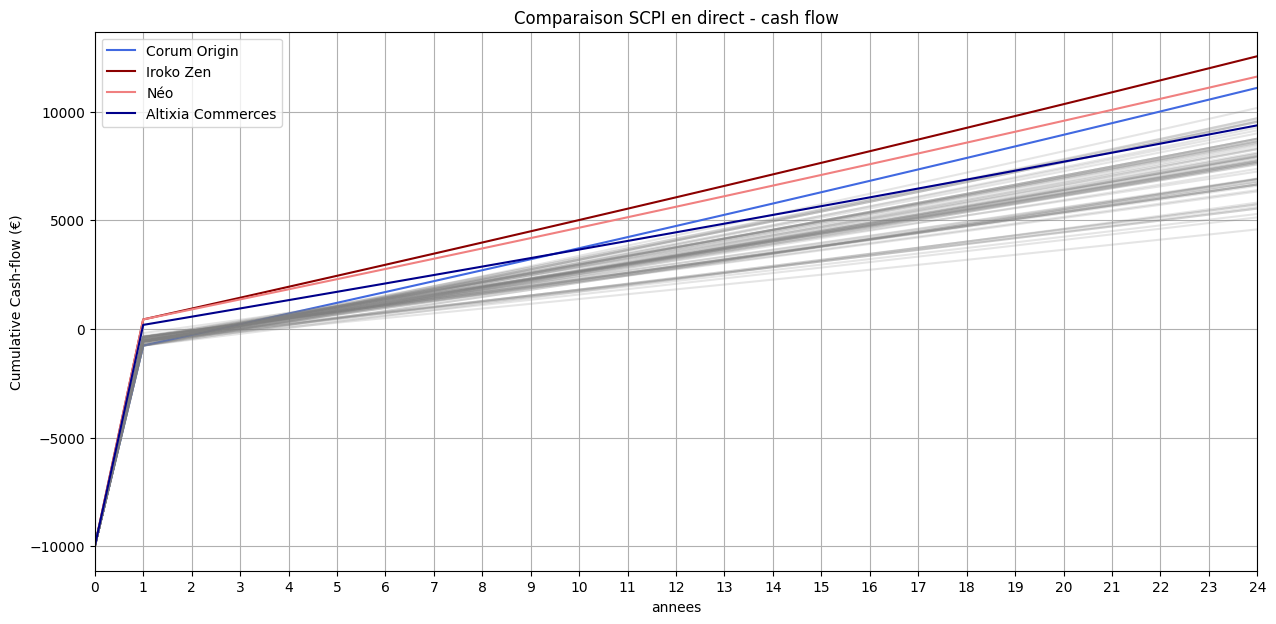

In [22]:
plt.figure(figsize=(15, 7))
for scpi_name in df_cash_flow_if_exit.columns:
    if scpi_name == "annee":
        continue
    elif scpi_name == "Iroko Zen":
        color="darkred"
        label=scpi_name
        alpha=1
    elif scpi_name == "Néo":
        color="lightcoral"
        label=scpi_name
        alpha=1
    elif scpi_name == "Corum Origin":
        color="royalblue"
        label=scpi_name
        alpha=1
    elif scpi_name == "Altixia Commerces":
        color="darkblue"
        label=scpi_name
        alpha=1
    else:
        color="grey"
        label=None
        alpha=.2
        
    plt.plot(df_cash_flow_if_exit["annee"], df_cash_flow_if_exit[scpi_name], color=color, label=label, alpha=alpha)

plt.title("Comparaison SCPI en direct - cash flow")
plt.grid()
plt.xlim(0, 20)
plt.xlabel("annees")
plt.ylabel("Cumulative Cash-flow (€)")
plt.xticks(df_cash_flow_if_exit["annee"], df_cash_flow_if_exit["annee"])
plt.legend()
plt.show()

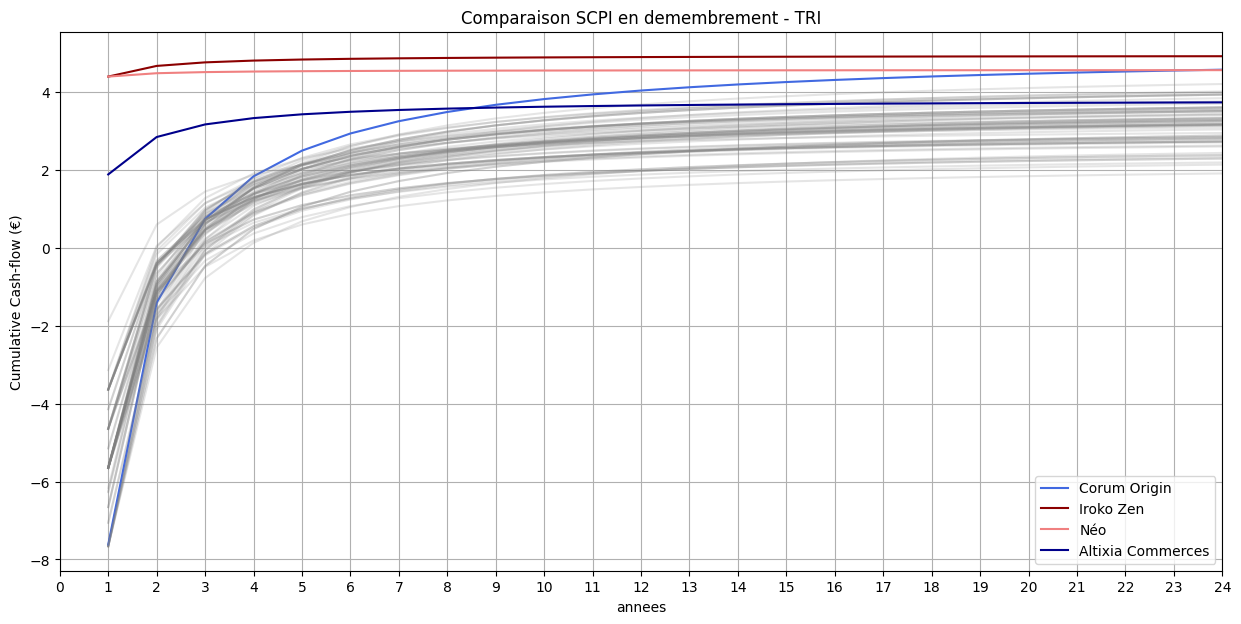

In [23]:
plt.figure(figsize=(15, 7))
for scpi_name in df_irr_if_exit.columns:
    if scpi_name == "annee":
        continue
    elif scpi_name == "Iroko Zen":
        color="darkred"
        label=scpi_name
        alpha=1
    elif scpi_name == "Néo":
        color="lightcoral"
        label=scpi_name
        alpha=1
    elif scpi_name == "Corum Origin":
        color="royalblue"
        label=scpi_name
        alpha=1
    elif scpi_name == "Altixia Commerces":
        color="darkblue"
        label=scpi_name
        alpha=1
    else:
        color="grey"
        label=None
        alpha=.2
        
    plt.plot(df_irr_if_exit["annee"], df_irr_if_exit[scpi_name], color=color, label=label, alpha=alpha)

plt.title("Comparaison SCPI en demembrement - TRI")
plt.grid()
plt.xlim(0, 20)
plt.xlabel("annees")
plt.ylabel("Cumulative Cash-flow (€)")
plt.xticks(df_cash_flow_if_exit["annee"], df_cash_flow_if_exit["annee"])
plt.legend()
plt.show()

Conclusion:
- On voit ici aussi le jeu entre les frais de souscription et les revenus:
    - Les SCPI sans frais de souscription ont le plus haut rendement a court terme ("la SCPI c'est un investissement a long terme, minimum 7 ans" ne s'applique pas pour ces SCPI). Note quelles ont des frais de souscription avant 3 ans que ne sont pas pris en compte ici.
    - Au contraire, les SCPI qui ont un gros rendement, mais aussi de gros frais de sousciption (e.g., Corum Origin) n'ont un interet qu'apres de nombreuses annees (e.g., 5+ ans)
    
**Attention, ce graph se base sur les performances passees, qui ne refletent pas les performances futures.**

# Demembrement vs en-direct

To do next:

- Compare en direct vs demembrement, selon le taux d'imposition

## Cas 1: avec des frais de souscription

In [25]:
frais_souscription, clee_repartition = get_data_demembrement()

/var/folders/2j/4p6d36k160v2dh6kk726g81h0000gq/T/ipykernel_93961/2803740073.py:18: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  clee_repartition.iloc[:, 1:] = clee_repartition.iloc[:, 1:].astype(float) / 100


In [35]:
df_direct = get_direct_info(
    apport=10000,
    cotisation_sociales=.175,
    tranche_marginale_impo=0,
    tdvm=.055,
    revalorisation_sous_jacent=.005,
    frais_souscription=0,
    max_annees_simulation=20,
)

df_demembrement = get_demembrement_info(
    apport=10000,
    clee_de_repartition=clee_repartition["Iroko Zen"],
    revalorisation_sous_jacent=.005,
    frais_souscription=0,
)

In [36]:
df_direct.columns

Index(['annee', 'cotisation_sociales', 'tranche_marginale_impo', 'tdvm',
       'revalorisation_sous_jacent', 'frais_souscription',
       'valeur_sous_jacent', 'loyers', 'impots_et_cs', 'loyers_net',
       'cash_flow', 'cum_cash_flow', 'cash_flow_if_exit',
       'cum_cash_flow_if_exit', 'irr_if_exit'],
      dtype='object')

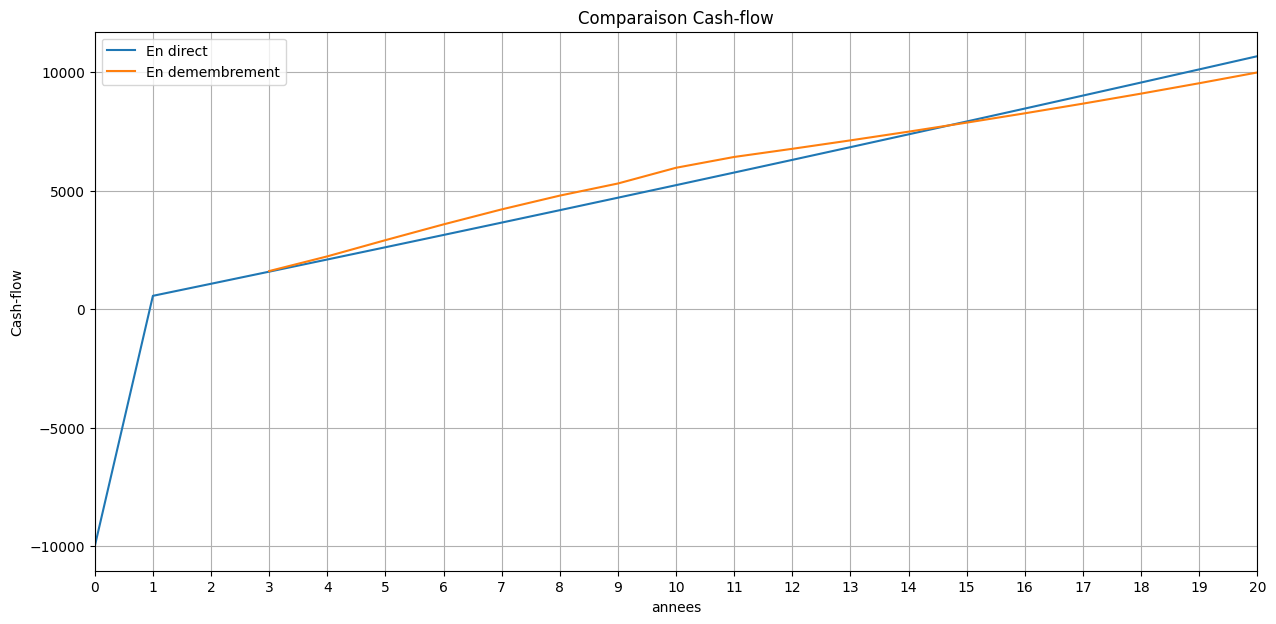

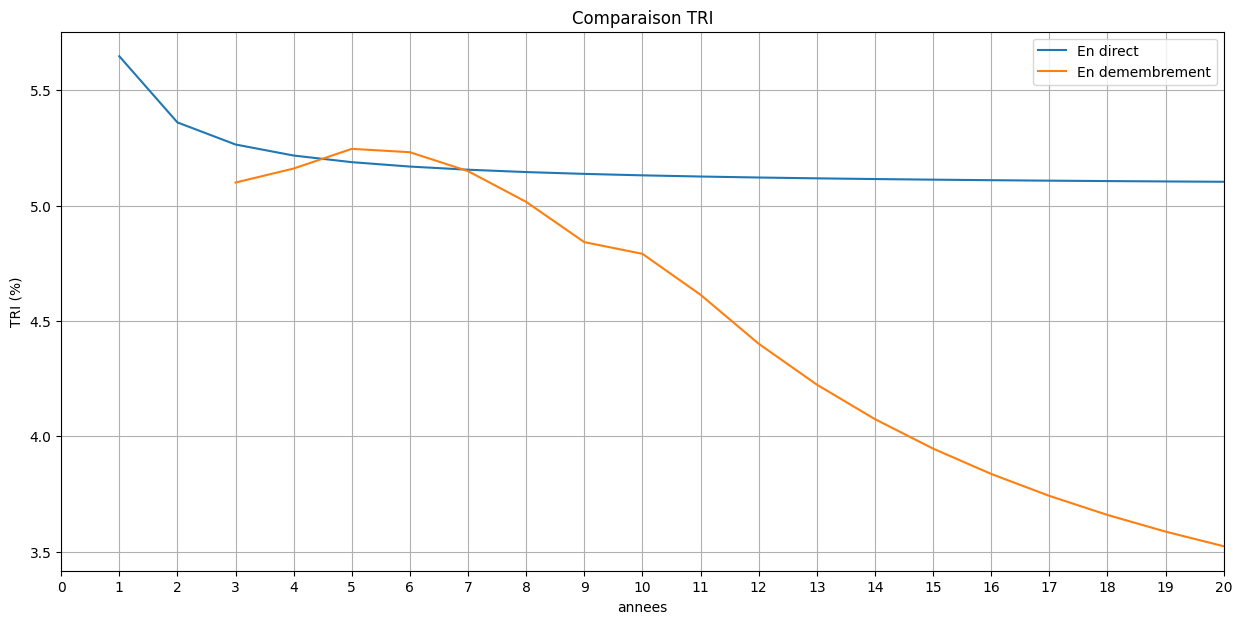

In [39]:
# Plot cash-flow
plt.figure(figsize=(15, 7))
plt.plot(df_direct["annee"], df_direct["cum_cash_flow_if_exit"], label="En direct")
plt.plot(df_demembrement["annee"], df_demembrement["cum_cash_flow_if_exit"], label="En demembrement")
plt.title("Comparaison Cash-flow")
plt.grid()
plt.xlim(0, 20)
plt.xlabel("annees")
plt.ylabel("Cash-flow")
plt.xticks(df_demembrement["annee"], df_demembrement["annee"])
plt.legend()
plt.show()

# Plot IRR
plt.figure(figsize=(15, 7))
plt.plot(df_direct["annee"], df_direct["irr_if_exit"], label="En direct")
plt.plot(df_demembrement["annee"], df_demembrement["irr_if_exit"], label="En demembrement")
plt.title("Comparaison TRI")
plt.grid()
plt.xlim(0, 20)
plt.xlabel("annees")
plt.ylabel("TRI (%)")
plt.xticks(df_demembrement["annee"], df_demembrement["annee"])
plt.legend()
plt.show()